# Tackling Overfitting
There are broadly 2 ways in which overfitting can be reduced,
1. Modification in model pipeline: Improving network configuration to solve over-parameterization.
2. Modification in data pipeline: Augmenting the dataset to increase the number of samples.

# Revisiting The Problem Statement And The Baseline Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

In [2]:
pd.set_option("display.max_columns", None)
sns.set_theme(style = "whitegrid")
warnings.filterwarnings("ignore")
tf.keras.utils.set_random_seed(111)

In [3]:
!tree clothing_dataset_small -d

clothing_dataset_small
├── test
│   ├── dress
│   ├── hat
│   ├── longsleeve
│   ├── outwear
│   ├── pants
│   ├── shirt
│   ├── shoes
│   ├── shorts
│   ├── skirt
│   └── t-shirt
├── train
│   ├── dress
│   ├── hat
│   ├── longsleeve
│   ├── outwear
│   ├── pants
│   ├── shirt
│   ├── shoes
│   ├── shorts
│   ├── skirt
│   └── t-shirt
└── validation
    ├── dress
    ├── hat
    ├── longsleeve
    ├── outwear
    ├── pants
    ├── shirt
    ├── shoes
    ├── shorts
    ├── skirt
    └── t-shirt

34 directories


In [4]:
print("\nLoading training data...")
train_data = tf.keras.utils.image_dataset_from_directory("clothing_dataset_small/train", shuffle = True)

print("\nLoading validation data...")
val_data = tf.keras.utils.image_dataset_from_directory("clothing_dataset_small/validation", shuffle = False)

print("\nLoading testing data...")
test_data = tf.keras.utils.image_dataset_from_directory("clothing_dataset_small/test", shuffle = False)


Loading training data...
Found 3068 files belonging to 10 classes.

Loading validation data...
Found 341 files belonging to 10 classes.

Loading testing data...
Found 372 files belonging to 10 classes.


In [5]:
# data preprocessing stage with resizing and rescaling operations
height = 128
width = 128

data_preprocessing = tf.keras.Sequential(
    name = "data_preprocessing",
    layers = [
        tf.keras.layers.Resizing(height, width), # shape preprocessing
        tf.keras.layers.Rescaling(1.0/ 255) # value preprocessing
    ]
)

# applying preprocessing on train, val and test dataset
train_ds = train_data.map(lambda x, y: (data_preprocessing(x), y), num_parallel_calls = tf.data.AUTOTUNE)
val_ds = val_data.map(lambda x, y: (data_preprocessing(x), y), num_parallel_calls = tf.data.AUTOTUNE)
test_ds = test_data.map(lambda x, y: (data_preprocessing(x), y), num_parallel_calls = tf.data.AUTOTUNE)

In [6]:
# baseline model
num_classes = 10
hidden_size = 256

model = tf.keras.Sequential(
    name = "model_baseline",
    layers = [
        tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (height, width, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = hidden_size, activation = "relu"),
        tf.keras.layers.Dense(units = num_classes, activation = "softmax")
    ]
)

# plotting the model architecture
# tf.keras.utils.plot_model(model, to_file = "model_baseline.png", show_shapes = True)

model.summary()

Model: "model_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,780,490 (64.01 MB)

 Trainable params: 16,780,490 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# compile the model with Cross-Entropy loss and Adam optimizer
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [8]:
# training for 10 epochs
model_fit = model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.2622 - loss: 3.7747 - val_accuracy: 0.4135 - val_loss: 1.8118
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.5567 - loss: 1.3797 - val_accuracy: 0.5337 - val_loss: 1.5116
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.7192 - loss: 0.9195 - val_accuracy: 0.5484 - val_loss: 1.4820
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8521 - loss: 0.5514 - val_accuracy: 0.5924 - val_loss: 1.4682
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9247 - loss: 0.3129 - val_accuracy: 0.5924 - val_loss: 1.4882
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9713 - loss: 0.1636 - val_accuracy: 0.6188 - val_loss: 1.5242
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9836 - loss: 0.0929 - val_accuracy: 0.6012 - val_loss: 1.8364
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9950 - loss: 0.0476 - val_accuracy: 0.5894 - v

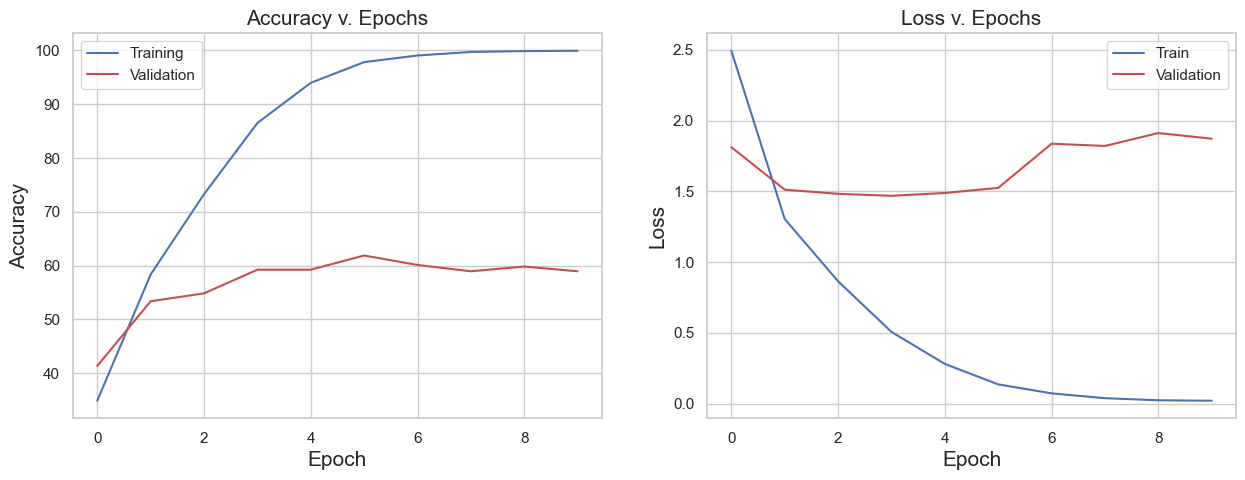

In [9]:
# plotting the training and validation loss and accuracy scores
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax = axes.ravel()

# accuracy graph
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["accuracy"]], label = "Training", color = "b")
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["val_accuracy"]], label = "Validation", color = "r")
ax[0].set_title("Accuracy v. Epochs", fontsize = 15)
ax[0].set_ylabel("Accuracy", fontsize = 15)
ax[0].set_xlabel("Epoch", fontsize = 15)
ax[0].legend()

# loss graph
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["loss"], label = "Train", color = "b")
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["val_loss"], label = "Validation", color = "r")
ax[1].set_title("Loss v. Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].set_xlabel("Epoch", fontsize = 15)
ax[1].legend()

plt.show()

In [10]:
# computing accuracy and plotting the confusion matrix on the test dataset

# load the model from the pretrained checkpoints
# model.load_weights("pretrained_checkpoints/L1_ann_model.ckpt")
# download link,
# https://drive.google.com/drive/folders/1wgRokkvPUoGjsUZqJEhtpJn5e5lDTL4i

# run the model prediction and obtain the probabilities
y_pred = model.predict(test_ds)

# store the list of predicted classes by taking the argmax of the probabilities
predicted_categories = tf.argmax(y_pred, axis = 1)

# extract the list of class names
class_names = test_data.class_names

# create a list of all y's labels by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis = 0)

# calculate accuracy
from sklearn import metrics

# test accuracy
metrics.accuracy_score(true_categories, predicted_categories) * 100

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-12-28 16:44:57.892625: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


52.956989247311824

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2024-12-28 16:44:58.479993: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


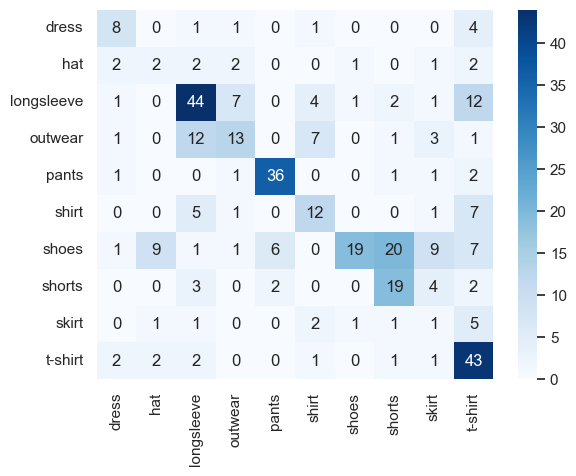

In [11]:
# note that the below logic does not work with shuffled datasets
def ConfusionMatrix(model, ds, label_list):
    # run the model prediction and obtain the probabilities
    y_pred = model.predict(ds)

    # get the list of predicted classes by taking the argmax of the probabilities (y_pred)
    predicted_categories = tf.argmax(y_pred, axis = 1)

    # create a list of all y's labels by iterating over the test dataset
    true_categories = tf.concat([y for x, y in ds], axis = 0)

    # plot a confusion matrix
    cm = metrics.confusion_matrix(true_categories, predicted_categories)
    sns.heatmap(cm, annot = True, xticklabels = label_list, yticklabels = label_list, cmap = "Blues", fmt = "g")
    plt.show()

ConfusionMatrix(model, test_ds, test_data.class_names)

### What is the most apparent issue with the plots above?
Validation accuracy is very low compared to training accuracy. This scenario is better known as overfitting.

### How to solve for overfitting in ML?
Overfitting in Machine Learning occurs when a model learns the training data too well, capturing noise and idiosyncrasies specific to the training set. This leads to poor performance on unseen data (test data).

Key strategies to combat overfitting,
1. Increase training data:
    - More data: The most effective way to combat overfitting is to increase the size and diversity of the training dataset. More data exposes the model to a wider range of examples, forcing it to learn more generalizable patterns.
    - Data augmentation: This technique artificially expands the training dataset by creating variations of existing data points. For images, this could involve rotations, flips, crops and color adjustments. For text, it could involve synonyms, back-translation or adding noise.
2. Reduce model complexity:
    - Smaller models: Using simpler models with fewer parameters can help prevent overfitting. This can involve,
        - Reducing the number of layers in a Neural Network.
        - Decreasing the number of nodes (Neurons) in each layer.
        - Choosing simpler model architecture (e.g., linear models instead of Deep Neural Networks).
    - Feature selection/ engineering: Carefully selecting or engineering relevant features can reduce the complexity of the model and improve its generalization ability.
3. Regularization:
    - L1/ L2 regularization (weight decay): This technique adds a penalty term to the loss function, encouraging the model to have similar weights. This discourages the model from relying too heavily on any single feature and prevents it from becoming overly complex.
    - Dropout: During training, randomly "drop" (set to zero) a fraction of Neurons in each layer. This prevents Neurons from co-adapting too strongly forcing them to learn more robut features.
4. Early stopping:
    - Monitor the model's performance on a validation set during training.
    - Stop training when the performance on the validation set starts to degrade, even though the performance on the training set might still be improving. This prevents the model from overfitting to the training data.

# Tackling Overfitting: Modifications In Model Pipeline
The baseline network has approximately 17 million parameters and just over 3000 images for training. This results in overparameterization of the network making it prone to overfit. One way to tackle this would be to remove some layers from the network. But since it is already a small network, that would badly affect the performance on both training or validation set.

Consider the result of `model.summary()`, observe that close to 99% of the parameters are associated with just one layer, and that is not even the convolutional layer. Although CNN is introduced in the model's architecture, the number of trainable parameters as as result of that is approximately 5000, which is 1000 times less than that of the Dense layers in architecture.

The reason for it is that when the 3D matrix of shape `32x32x32` is flattened into 1D, the number of connections from that layer to Dense layer explodes exponentially (no weight sharing in MLP).

In order to avoid this, the following can be tried,
1. Reduce the 3D volume before the flatten layer by using more convolutions blocks.
2. Replace the flatten layer by `GlobalAveragePooling2D`.

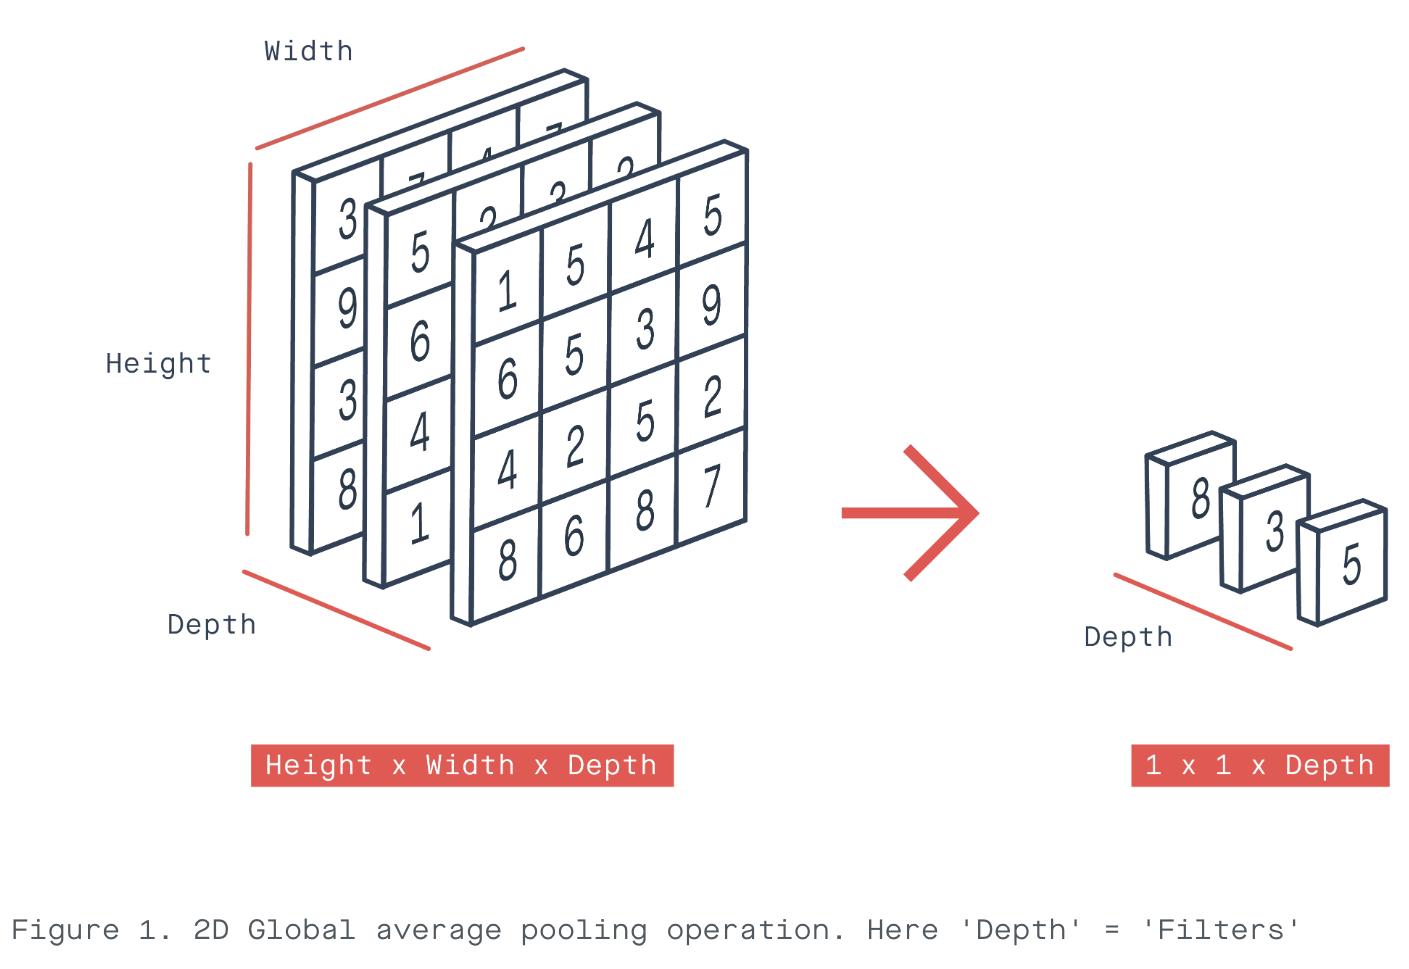

`GlobalAveragePooling2D` takes an input tensor of size `(input width) x (input height) x (input channel)`. It computes the average values across the `(input width) x (input height)` matrix for each of the `(input channels)`.

### Modification 1

In [12]:
num_classes = 10
hidden_size = 256

model = tf.keras.Sequential(
    name = "model_cnn_1",
    layers = [
        tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = "same", activation = "relu", input_shape = (128, 128, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = "same", activation = "relu"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units = hidden_size, activation = "relu"),
        tf.keras.layers.Dense(units = num_classes, activation = "softmax")
    ]
)

In [13]:
model.summary()

Model: "model_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,970 (1.76 MB)

 Trainable params: 460,970 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# compiling
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [15]:
# training for 10 epochs
model_fit = model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.2622 - loss: 2.1543 - val_accuracy: 0.2463 - val_loss: 2.1618
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.2861 - loss: 2.0693 - val_accuracy: 0.3109 - val_loss: 2.0139
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.3356 - loss: 1.9358 - val_accuracy: 0.3490 - val_loss: 1.9114
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.3784 - loss: 1.8103 - val_accuracy: 0.3607 - val_loss: 1.8002
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.4296 - loss: 1.6898 - val_accuracy: 0.4135 - val_loss: 1.7873
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.4678 - loss: 1.5604 - val_accuracy: 0.4545 - val_loss: 1.6005
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.5223 - loss: 1.3896 - val_accuracy: 0.5367 - val_loss: 1.4052
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.5668 - loss: 1.2605 - val_accu

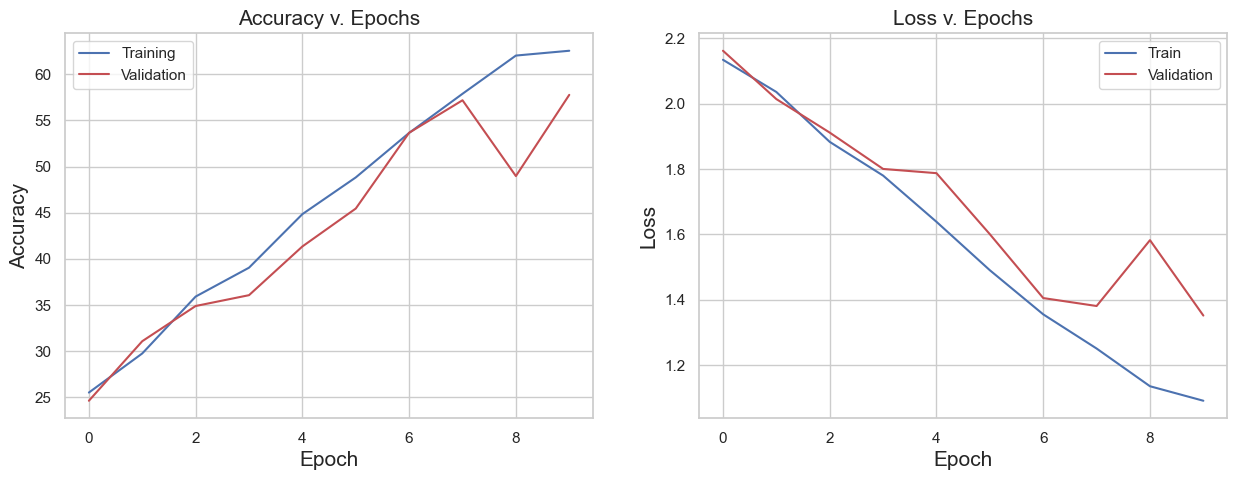

In [16]:
# plotting the training and validation loss and accuracy scores
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax = axes.ravel()

# accuracy graph
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["accuracy"]], label = "Training", color = "b")
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["val_accuracy"]], label = "Validation", color = "r")
ax[0].set_title("Accuracy v. Epochs", fontsize = 15)
ax[0].set_ylabel("Accuracy", fontsize = 15)
ax[0].set_xlabel("Epoch", fontsize = 15)
ax[0].legend()

# loss graph
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["loss"], label = "Train", color = "b")
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["val_loss"], label = "Validation", color = "r")
ax[1].set_title("Loss v. Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].set_xlabel("Epoch", fontsize = 15)
ax[1].legend()

plt.show()

With only 2 modifications in the architecture, the model seems to be performing much and the problem of overfitting seems to be vanishing.

Observe that the model's performance seemed to be increasing before it was stopped after 10 epochs leading to underfitting.

But how many more epochs to train for? This obviously cannot be known. But, there are a few references based on which the decision can be made. They are,
1. Early stopping:
    - Monitor validation loss: Continuously evaluate the model's performance on a separate validation dataset.
    - Stop training when the validation loss increases: Once the validation loss starts to increase after a certain number of epochs, it suggests that the model is beginning to overfit the training data.
    - Save the best model: Save the model's weights at the epoch with the lowest validation loss.
2. Plateauing loss:
    - Monitor training loss: Observe the training loss over epochs.
    - Stop training when the loss plateaus: If the training loss stops decreasing significantly, it indicates that the model has reached a point of diminishing returns.
3. Performance metrics:
    - Define relevant metrics: Choose metrics that align with the task at hand (e.g., Accuracy, F1-Score, Precision, Recall).
    - Monitor performance on validation set: Track the chosen metrics on the validation set.
    - Stop training when performance saturates: If the performance on the validation set stops improving, consider stopping the training.
4. Computational resources: If there are limited resources or if there is limited time, a maximum epoch number training time may have to be set.
5. Other constriants:
    - Hyperparameter tuning: The optimal stopping point can also depend on hyperparameter settings. Different parameters have to be experimented with to find the best combination.
    - Data size and complexity: The amount of training data and complexity of the task can influence the appropriate stopping point.

Visualize training process: Plotting the training and validation loss, as well as performance metrics, over epochs can help in visualizing the training process and identify the optimal stopping point.

In [17]:
# compiling
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [18]:
# training for 30 epochs
model_fit = model.fit(train_ds, validation_data = val_ds, epochs = 30)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.6654 - loss: 0.9885 - val_accuracy: 0.6188 - val_loss: 1.1697
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.7193 - loss: 0.8658 - val_accuracy: 0.6393 - val_loss: 1.0977
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.7195 - loss: 0.8375 - val_accuracy: 0.6276 - val_loss: 1.1273
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.7256 - loss: 0.7775 - val_accuracy: 0.6452 - val_loss: 1.1211
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.7490 - loss: 0.7187 - val_accuracy: 0.6276 - val_loss: 1.0533
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.7572 - loss: 0.6937 - val_accuracy: 0.6686 - val_loss: 1.0443
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.7784 - loss: 0.6394 - val_accuracy: 0.6569 - val_loss: 1.0552
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.8163 - loss: 0.5318 - val_accu

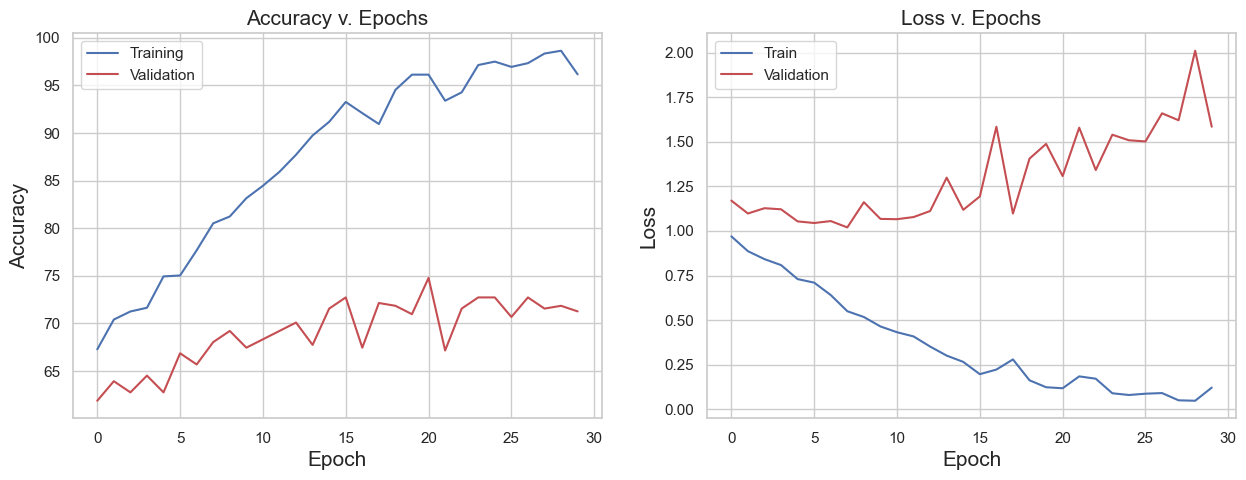

In [19]:
# plotting the training and validation loss and accuracy scores
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax = axes.ravel()

# accuracy graph
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["accuracy"]], label = "Training", color = "b")
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["val_accuracy"]], label = "Validation", color = "r")
ax[0].set_title("Accuracy v. Epochs", fontsize = 15)
ax[0].set_ylabel("Accuracy", fontsize = 15)
ax[0].set_xlabel("Epoch", fontsize = 15)
ax[0].legend()

# loss graph
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["loss"], label = "Train", color = "b")
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["val_loss"], label = "Validation", color = "r")
ax[1].set_title("Loss v. Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].set_xlabel("Epoch", fontsize = 15)
ax[1].legend()

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


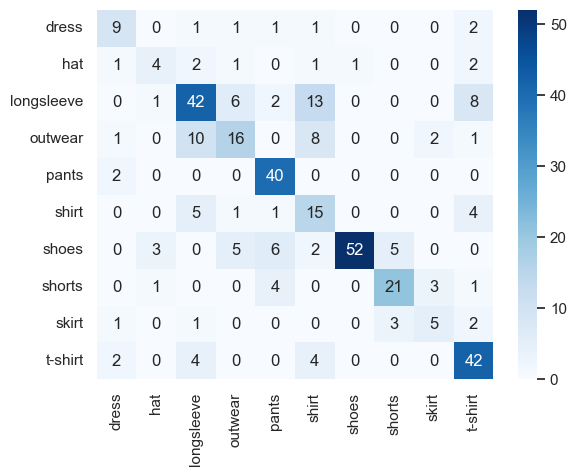

In [21]:
ConfusionMatrix(model, test_ds, test_data.class_names)

A massive improvement in performance is seen on the test dataset. Obviously, many more improvement can be made to the architecture (which will be seen).

### Modification 2
It is known that by adding `Dropout` and `BatchNormalization` helps in regularizing the model, thereby improving the performance on validation dataset. Therefore,
- `BatcNormalization` is added after every `Conv2D` and `Dense` layers.
- `Dropout` is added after `Dense` layers.

What is `Dropout` and why is it required?
- `Dropout` is used to randomly drop the neurons from the network during training.
- `Dropout` helps in reducing overfitting by reducing over-reliability of the network on using certain features to identify in a image. `Dropout` thus encourages the network to utilize all the features to find pattern in an image. This increases the overall generalization of our model, thereby giving good model performance.
- `Dropout` is only used during training and not while evaluating the model. This is because, the capability of every learned Neuron should be used and none of them should be skipped at random during evaluation.

